In [2]:
import pandas as pd
import numpy as numpy
from matplotlib import pyplot as plt
import os
import seaborn as sns
# from wordcloud import WordCloud
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import re
import json
import networkx as nx
%matplotlib inline

In [3]:
peru = pd.read_csv("/Users/bregy/Documents/signals/peru1h.csv")

In [15]:
peru["conversation_id"].value_counts()

1266501034207305730    527
1266373850029158400    469
1266421474694508550    319
1266210285389524995    215
1266127275017322498    180
                      ... 
1266406448247996417      1
1266441678786670593      1
1266353665616629766      1
1266158927617634305      1
1266199923520872449      1
Name: conversation_id, Length: 23201, dtype: int64

In [9]:
iquitos.keys()

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'mentions', 'urls',
       'photos', 'replies_count', 'retweets_count', 'likes_count', 'hashtags',
       'cashtags', 'link', 'retweet', 'quote_url', 'video', 'near', 'geo',
       'source', 'user_rt_id', 'user_rt', 'retweet_id', 'reply_to',
       'retweet_date', 'translate', 'trans_src', 'trans_dest'],
      dtype='object')

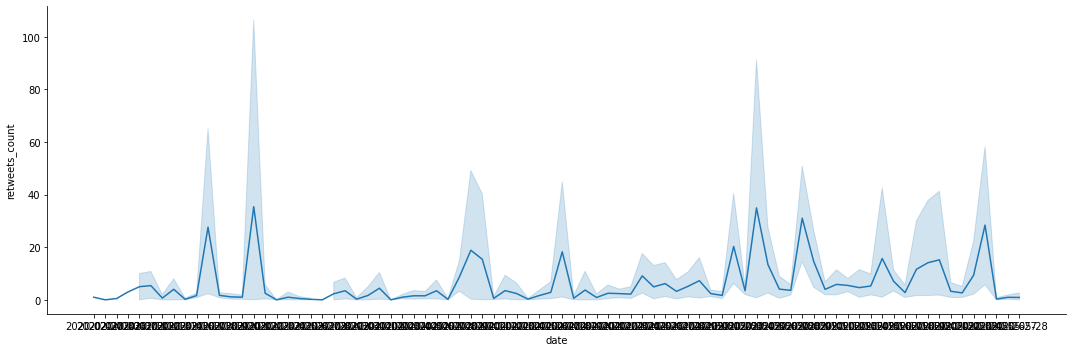

In [4]:
sample = peru#.sample(500)
sns.relplot(x="date", y="retweets_count", kind="line", aspect=3, data=sample)

In [370]:
peru["username"].value_counts()

peru21noticias     176
peru_noticias      168
perunews           143
movistarperu       140
elcomercio_peru    139
                  ... 
whitechinawhite      1
sdsualumni           1
rafaguillenp         1
dancilot             1
caponte4606          1
Name: username, Length: 19854, dtype: int64

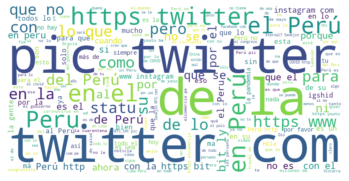

In [372]:
total_text = ". ".join([str(t) for t in peru["tweet"]])
wc = WordCloud(background_color="white", repeat=True, width=800, height=400)
wc.generate(total_text)

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

In [374]:
documents_list = [str(t) for t in peru["tweet"]]

In [375]:
black_list = ["http", "https", "com", "twitter", "fund", "relief", "pic", "www", "pe"]
tokenizer = RegexpTokenizer(r'\w+')
es_stop = set(stopwords.words('spanish'))
en_stop = set(stopwords.words('english'))
p_stemmer = PorterStemmer()
texts = []
for i in documents_list:
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)
    stopped_tokens = [i for i in tokens if not i in es_stop]
    stopped_tokens = [i for i in stopped_tokens if not i in en_stop]
    stopped_tokens = [i for i in stopped_tokens if not i in black_list]
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    texts.append(stemmed_tokens)

In [376]:
# corpus
dictionary = corpora.Dictionary(texts)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in texts]

In [377]:
number_of_topics = 12
number_of_words = 6
lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)
print(lsamodel.print_topics(num_topics=number_of_topics, num_words=number_of_words))

[(0, '0.792*"perú" + 0.320*"peru" + 0.118*"1" + 0.117*"si" + 0.115*"q" + 0.114*"coronaviru"'), (1, '0.813*"peru" + -0.458*"perú" + 0.229*"1" + 0.086*"coronaviru" + 0.072*"19" + 0.071*"covid"'), (2, '-0.866*"1" + 0.294*"peru" + -0.192*"2" + -0.137*"3" + -0.088*"chile" + -0.085*"4"'), (3, '-0.873*"q" + -0.250*"si" + 0.144*"perú" + 0.126*"coronaviru" + 0.119*"19" + 0.112*"covid"'), (4, '0.515*"covid" + 0.493*"19" + 0.289*"coronaviru" + -0.263*"peru" + 0.221*"q" + 0.217*"caso"'), (5, '-0.819*"si" + 0.359*"q" + 0.152*"perú" + -0.095*"statu" + -0.078*"gobierno" + -0.078*"solo"'), (6, '-0.311*"1" + -0.306*"statu" + 0.295*"chile" + 0.274*"colombia" + 0.238*"ecuador" + 0.219*"argentina"'), (7, '-0.864*"statu" + 0.129*"perú" + -0.123*"chile" + -0.118*"colombia" + 0.113*"1" + 0.108*"si"'), (8, '0.292*"4" + -0.261*"covid" + -0.252*"chile" + -0.244*"colombia" + -0.240*"19" + 0.237*"3"'), (9, '0.418*"x" + 0.200*"pued" + 0.197*"hola" + 0.187*"favor" + 0.172*"año" + 0.169*"saludo"'), (10, '0.381*"p" +

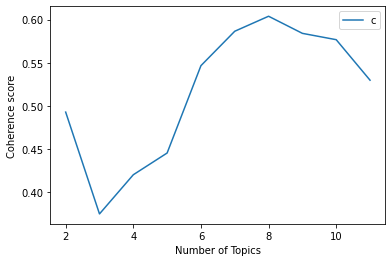

In [378]:
# fitting coherence
start = 2
step = 1
stop = 12
coherence_values = []
model_list = []

for num_topics in range(start, stop, step):
    # generate LSA model
    model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

x = range(start, stop, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [379]:
number_of_topics = 8
number_of_words = 10
lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)
for topic in lsamodel.show_topics(num_topics=number_of_topics, num_words=number_of_words):
    print(topic)

(0, '0.792*"perú" + 0.320*"peru" + 0.117*"1" + 0.116*"si" + 0.115*"q" + 0.114*"coronaviru" + 0.112*"statu" + 0.106*"covid" + 0.099*"19" + 0.079*"chile"')
(1, '0.814*"peru" + -0.458*"perú" + 0.225*"1" + 0.086*"coronaviru" + 0.070*"19" + 0.069*"covid" + 0.060*"2" + 0.058*"2020" + 0.055*"4" + 0.051*"3"')
(2, '-0.861*"1" + 0.292*"peru" + -0.194*"2" + -0.144*"3" + -0.094*"4" + -0.089*"chile" + -0.080*"ecuador" + -0.078*"colombia" + -0.073*"argentina" + 0.071*"q"')
(3, '-0.872*"q" + -0.251*"si" + 0.145*"perú" + 0.127*"coronaviru" + 0.115*"19" + 0.108*"covid" + -0.074*"solo" + -0.071*"gobierno" + -0.069*"1" + -0.065*"x"')
(4, '0.510*"covid" + 0.489*"19" + 0.293*"coronaviru" + -0.264*"peru" + 0.226*"caso" + 0.215*"q" + -0.181*"perú" + 0.164*"4" + -0.136*"statu" + 0.125*"noticia"')
(5, '-0.667*"si" + 0.323*"q" + -0.244*"statu" + -0.173*"1" + 0.164*"chile" + 0.151*"colombia" + 0.132*"ecuador" + 0.125*"argentina" + -0.121*"covid" + 0.110*"perú"')
(6, '0.369*"si" + -0.313*"1" + 0.244*"3" + 0.231*"

In [82]:
from nltk.corpus import movie_reviews
movie_reviews

<CategorizedPlaintextCorpusReader in '/Users/bregy/nltk_data/corpora/movie_reviews'>

In [83]:
documents = [(list(movie_reviews.words(fileid)), category) for category in movie_reviews.categories() for fileid in movie_reviews.fileids(category)]

In [393]:
def fix_tweet(message:str) -> str:
    words = [w for w in message.split(" ") if not w.startswith("http")]
    words = [w for w in words if len(w) < 12]
    return " ".join(words).replace("\n", "").strip()

0        20.05.30 [ معلومه ]\n\nظهر فيديو لتايهيونج من ...
1                                                  😜😉☺️🙏🏼😘
2        Amigaaaaaaa\n😍😭 qué precioso tu mensaje y qué ...
3        I am a Liverpool fan, but I would have to say ...
4                         Youcan't be this stupid... 🤦🏽‍♂️
                               ...                        
38037    Mal, Evie, Carlos, Uma, Jay... ¡Vuelve a ver a...
38038    🇵🇪🗓 JUEVES 28 de MAYO\nReporte │#COVID19 PERÚ\...
38039    @Xileone\n¿Hasta cuándo se va a seguir jodiend...
38040    Día de la hamburguesa: ¿cuál es la historia de...
38041    CEsar Vallejo presenta su propuesta para el in...
Name: tweet, Length: 38042, dtype: object

In [394]:
df = peru.copy()
df["tweet"] = df["tweet"].map(lambda t: str(t))
df["tweet"] = df["tweet"].map(fix_tweet)
df

In [399]:
g = nx.DiGraph()
relations = df["username"].copy()
for i, tweet in df.iterrows():
    for r in json.loads(tweet["reply_to"].replace("'", '"')):
        g.add_edge(tweet["username"], r["username"], tweet=tweet["tweet"], likes=tweet["likes_count"])

valid_nodes = []
for node in g.nodes:
    if g.degree[node] > 2:
        valid_nodes.append(node)
print(len(valid_nodes))
g_valid = g.subgraph(valid_nodes)

12942


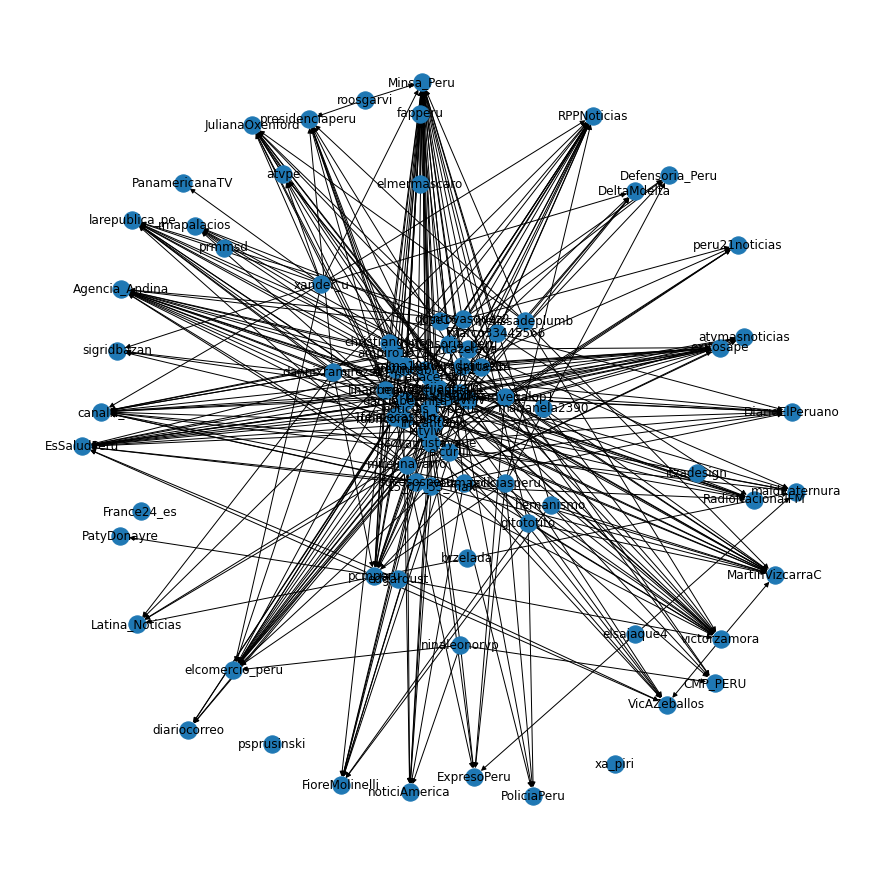

In [342]:
plt.figure(1, figsize=(12,12)) 
nx.draw_spring(g_valid, with_labels=True)

In [360]:
j_nodes = []
j_edges = []
aux_ids = {}
for i, node in enumerate(g_valid.nodes):
    aux_ids[node] = i
    j_nodes.append({"id": i, "value": g_valid.degree[node],"label": node})
for edge in g_valid.edges:
    j_edges.append({"from":aux_ids[edge[0]], "to":aux_ids[edge[1]]})

In [400]:
nx.write_gexf(g_valid, "peru_dense.gexf")

In [397]:
df.keys()

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'mentions', 'urls',
       'photos', 'replies_count', 'retweets_count', 'likes_count', 'hashtags',
       'cashtags', 'link', 'retweet', 'quote_url', 'video', 'near', 'geo',
       'source', 'user_rt_id', 'user_rt', 'retweet_id', 'reply_to',
       'retweet_date', 'translate', 'trans_src', 'trans_dest'],
      dtype='object')

In [398]:
df["likes_count"]

0         0
1         0
2         0
3         0
4         0
         ..
38037     0
38038     0
38039     0
38040    67
38041     0
Name: likes_count, Length: 38042, dtype: int64

In [29]:
import nest_asyncio
nest_asyncio.apply()
import twint
from datetime import datetime

In [28]:
del twint

In [41]:
c = twint.Config()
c.Since = str(datetime(2020, 5, 28, 0))
c.Until = str(datetime(2020, 5, 29, 0))
c.Search = "peru"
c.Limit = 10
c.Store_object = True

twint.run.Search(c)

1266157299036573701 2020-05-28 18:59:58 -0500 <LuzMalcaNuez> Y eso tiene que ser así,no vamos a olvidar tan pronto ,de que lado se puso ante la desgracia,por una pandemia,y que cada día aplaudía, para que al Perú le fuera mal.
1266157293441290241 2020-05-28 18:59:57 -0500 <WildChildDreea> Gracias Bruno!! Me pongo a ello, y qué sepas que Fugitivos es mi bucle permanente. Saludos desde Perú 💕
1266157289314177026 2020-05-28 18:59:56 -0500 <EfDenCT> #muerdagomisilfanart #pvz2itsabouttime #tradicionalart #premiumplants en Ate, Lima, Peru  https://www.instagram.com/p/CAwDiKeHdXM0C6CY2lrIsa3VnYXNnfIHA6d6k00/?igshid=63rjmy31wur3 …
1266157288068390918 2020-05-28 18:59:56 -0500 <Carlos89366332> X q rendirán q darle pensión a ese muchacho Garcia no fue un ejemplo de nada bueno solo para sus seguidores q siguen creyendo q es puro ,después q hizo x el Perú nada de nada así q de una vez esa pensión para la gente q más necesita pero x favor la ministra de inclusión no entre
1266157277205204993 2020-0

In [45]:
twint.run.output.tweets_list